In [12]:
import os
import sys
import util
import params
import shutil
import random
import librosa
import librosa.display
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

from cnn import cnn
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.layers.experimental import preprocessing

sns.set_style('darkgrid')

In [13]:
# Check for any available GPU to utilize during training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [14]:
# Project Paths
_ROOT_DIR = os.path.dirname(pathlib.Path.cwd())
_DATASET_DIRECTORY_PATH = _ROOT_DIR+'/data/speech_commands'
_DOWNLOAD_URL = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
_PATH_TO_RESULTS = _ROOT_DIR+'/results'
_PATH_TO_MODEL = _PATH_TO_RESULTS+'/model.h5'

### Download, extract and partition data into datasets for training, validation and testing

In [15]:
# Check if dataset directory already exist, otherwise download, extract and remove the archive
if not os.path.isdir(_DATASET_DIRECTORY_PATH):
    if not os.path.isdir(_ROOT_DIR+'/data'):
        os.mkdir(_ROOT_DIR+'/data')
    print('Downloading from ' + _DOWNLOAD_URL)
    util.download_file(_DOWNLOAD_URL, _ROOT_DIR+'/data/speech_commands.tar.gz')
    print("Extracting archive...")
    shutil.unpack_archive(
        _ROOT_DIR+'/data/speech_commands.tar.gz', _DATASET_DIRECTORY_PATH)
    os.remove(_ROOT_DIR+'/data/speech_commands.tar.gz')
    print("Done.")

    # Create samples for the 'silence' category using the _background_noises_ recordings
    silence_samples = random.randint(1500, 4000)
    util.generateSilenceSamples(silence_samples, _DATASET_DIRECTORY_PATH)
    

_PATH_TO_NOISE_SRC = [os.path.join(_DATASET_DIRECTORY_PATH+'/_background_noise_', name)
                            for name in os.listdir(_DATASET_DIRECTORY_PATH+'/_background_noise_') if name.endswith('.wav')]

In [16]:
data_dir = pathlib.Path(_DATASET_DIRECTORY_PATH)
label_names = tf.io.gfile.glob(str(data_dir) + '/*')
label_names = [name for name in label_names if not name.endswith('_background_noise_')]

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if '_background_noise_' not in filename]
filenames = tf.random.shuffle(filenames)

train_samples = int(len(filenames) * params.DATASET_SPLIT[0])
val_samples = int(len(filenames) * params.DATASET_SPLIT[1])

train, remainder = filenames[:train_samples], filenames[train_samples:]
val, test = remainder[:val_samples], remainder[val_samples:]


### Visualize data set

Samples per label:
 {'one': 3890, 'no': 3941, 'five': 4052, 'dog': 2128, 'bird': 2064, 'eight': 3787, 'visual': 1592, 'on': 3845, 'forward': 1557, 'marvin': 2100, 'six': 3860, 'go': 3880, 'backward': 1664, 'left': 3801, 'learn': 1575, 'off': 3745, 'four': 3728, 'tree': 1759, 'stop': 3872, 'zero': 4052, 'right': 3778, 'sheila': 2022, 'wow': 2123, 'bed': 2014, 'down': 3917, 'nine': 3934, 'two': 3880, 'yes': 4044, 'three': 3727, 'up': 3723, 'cat': 2031, 'happy': 2054, 'follow': 1579, 'house': 2113, 'silence': 2656, 'seven': 3998} 

Balanced class weights:
 {0: 0.13436405431783163, 1: 3.4037713353413657, 2: 2.2355135179690078, 3: 2.2939397783980375, 4: 2.4282612588414363, 5: 2.3079950642498512, 6: 2.37843111461896, 7: 2.3929107111346393, 8: 2.351213697442566, 9: 2.413996439697374, 10: 2.3348183539944904, 11: 2.330004295532646} 



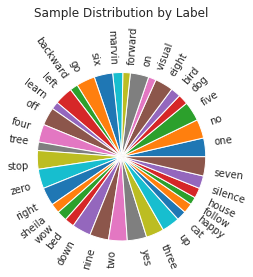

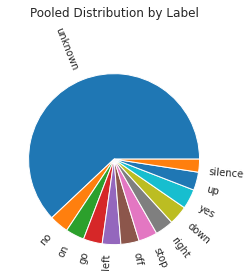

In [18]:
# Plot Sample distribution
samples_per_label = { label.split('/')[-1]: len(tf.io.gfile.listdir(str(label))) for label in label_names if os.path.isdir(label)}
labels = list(samples_per_label.keys())
counts = list(samples_per_label.values())

print("Samples per label:\n", samples_per_label, "\n")
plt.figure(1)
plt.pie(counts, labels=labels, rotatelabels=True)
plt.xticks(rotation=90)
plt.suptitle('Sample Distribution by Label')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(_ROOT_DIR+'/docs/images/sample_distribution.png')

# It's fine per class but since we will aggregate all classes except ['silence', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
# into unknown we'll have a heavily skewed set towards the unknown label.
# Use class weighting to combat this

# Dictionary that maps classes (indices) to weights (floats)
# Aggregate unknown class
class_weights = {'unknown': 0}
for label in samples_per_label:
    if label not in params.WORDS:
        class_weights['unknown'] += samples_per_label[label]
    else:
        class_weights[label] = samples_per_label[label]

plt.figure(2)
words = list(class_weights.keys())
word_counts = list(class_weights.values())
plt.pie(word_counts, labels=words, rotatelabels=True)
plt.xticks(rotation=90)
plt.suptitle('Pooled Distribution by Label')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(_ROOT_DIR+'/docs/images/pooled_sample_distribution.png')

# Calculate the weights
class_weights = { label_id : len(filenames) / ( len(params.WORDS) * class_weights[label]) for label_id, label in enumerate(params.WORDS)}
print("Balanced class weights:\n", class_weights, "\n")




### Declare methods for loading, preprocessing and augmentating data

In [7]:
def decode_audio(audio_binary):
    """Decodes a 16-bit WAV file to a float tensor, values scaled between -1.0 and 1.0

    Args:
        audio_binary (tf.Tensor[string]): [description] The WAV-encoded audio from a file.
    Returns:
        [tf.Tensor[float]]: [description] A float tensor with values between -1.0 and 1.0 representing the audio.
    """  
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def encode_label(signal, label):
    """Encodes the label with a number"""  
    label = tf.argmax(label == params.WORDS)
    return signal, label

def get_sample(source_file):
    """Reads source audio file and label into the tensor representations.
       The audio file gets decoded gets zero-padded if necessary.

    Args:
        source_file (tf.Tensor[String]): [description]. The path to the source audio file
    Returns:
        [tf.Tensor[float]]: [description] The decoded and padded audio signal
        [tf.Tensor[string]]: [description] The label of the sample
    """
    label = tf.strings.split(source_file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(source_file)
    signal = decode_audio(audio_binary)

    # Add padding in case the source file has less than _SAMPLE_RATE samples
    padding = tf.zeros([params.SAMPLE_RATE] - tf.shape(signal), dtype=tf.float32)
    signal = tf.cast(signal, tf.float32)
    padded_signal = tf.concat([signal, padding], 0)

    return padded_signal, label

def add_noise(padded_signal, label):
    """Method for data augmentation. Adds randomly selected noise from sources in
       _background_noise_ to the input signal.

    Args:
        padded_signal (tf.Tensor[float]): [description]. The input signal
    Returns:
        [tf.Tensor[float]]: [description]  The input signal with noise added
        [tf.Tensor[string]]: [description] The label of the sample
    """
    noise_source = random.choice(_PATH_TO_NOISE_SRC)
    audio_binary = tf.io.read_file(noise_source)
    noise = decode_audio(audio_binary)
    
    # Choose random section of the noise file
    offset = tf.random.uniform((), minval=0, maxval=tf.shape(noise)[0] - params.SAMPLE_RATE, dtype=tf.int32)
    slice_indices = tf.range(0, params.SAMPLE_RATE, dtype=tf.int32)
    noise_segment = tf.gather(noise, slice_indices + offset, axis=0)
    return tf.math.add(padded_signal, noise_segment), label

def configure_data_stream(audio_files, data_augmentation=False):
    """Creates an input pipeline by reading from the source data, applying transformations for
       preprocessing and (optionally) data augmentation. Output data consists of a feature set
       and the encoded labels.

    Args:
        audio_files (tf.Tensor[string]): [description]. The list of files to use as input data
        data_augmentation (boolean, optional): [description]. Whether to apply data augmenting transformations or not.                                                                                      Defaults to false.
    Returns:
        [tf.data.Dataset]: A source dataset for the given input data
    """
    ds = tf.data.Dataset.from_tensor_slices(audio_files)
    ds = ds.map(get_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if data_augmentation and (random.uniform(0, 1) >= 0.5):
        ds = ds.map(add_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(encode_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds


### Visualizing the extracted features from some audio samples

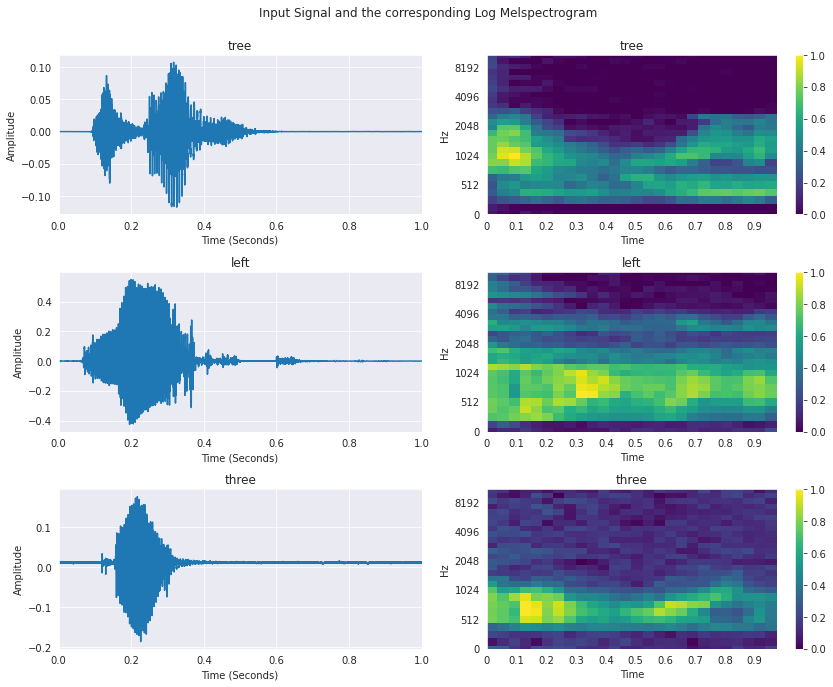

In [35]:
# Visual representation of the source audio and the corresponding features extracted
original_ds = tf.data.Dataset.from_tensor_slices(train).map(get_sample)
feature_ds = tf.data.Dataset.from_tensor_slices(train).map(get_sample).map(util.generate_log_mel_spectrograms,num_parallel_calls=tf.data.experimental.AUTOTUNE)

fig, axes = plt.subplots(3, 2, figsize=(12,10))
fig.suptitle('Input Signal and the corresponding Log Melspectrogram')
for idx, ((signal, label),(feature, _)) in enumerate(zip(original_ds.take(3), feature_ds.take(3))):
    ax = axes[idx][0]
    ax.plot(np.linspace(0, 1, len(signal.numpy())), signal.numpy())
    ax.set_title(label.numpy().decode('UTF-8'))
    ax.set_xlim(0, 1)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (Seconds)")

    ax = axes[idx][1]
    img = librosa.display.specshow(np.squeeze(feature.numpy()), sr=params.SAMPLE_RATE,
                                   hop_length=params.HOP_SIZE, x_axis='time', y_axis='mel',
                                   cmap='viridis', ax=ax);
    fig.colorbar(img, ax=ax)
    ax.grid(False)
    ax.set_title(label.numpy().decode('UTF-8'))
    ax.set_ylabel("Hz")
    ax.set_xlabel("Time")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    

## Set up data streams for the datasets

In [9]:
train_ds = configure_data_stream(train, data_augmentation=True).prefetch(tf.data.experimental.AUTOTUNE).batch(params.BATCH_SIZE).repeat(params.EPOCHS)

# Cache validation set since it will be used repeatedly and wont change due to any data augmentation
val_ds = configure_data_stream(val).prefetch(tf.data.experimental.AUTOTUNE).batch(params.BATCH_SIZE).repeat(params.EPOCHS)
val_ds.cache()

# Test samples will be evaluated individually, once only
test_ds = configure_data_stream(test).batch(1)

## Set up and train the model

In [10]:
model = cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'],
)

model.summary()


# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    _PATH_TO_MODEL, save_best_only=True, monitor='val_loss', mode='min')

# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-5, mode='min')

early_stopping = callbacks.EarlyStopping(verbose=1, patience=3)

tensorboard = callbacks.TensorBoard(
    log_dir=_PATH_TO_RESULTS+'/logs', histogram_freq=1)


history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=params.EPOCHS,
    steps_per_epoch=int(train_samples/params.BATCH_SIZE),
    validation_steps=int(val_samples/params.BATCH_SIZE),
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, tensorboard])

model.save(_PATH_TO_MODEL)


test_labels = []
for _, label in test_ds:
  test_labels.append(label.numpy()[0])

test_labels = np.array(test_labels)
y_pred = np.argmax(model.predict(test_ds, verbose=1), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print("Test set accuracy: {:.0%}".format(test_acc))


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_melgram_layer (LogMelgra (None, 27, 26, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 24, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 23, 32)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 22, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 21, 128)       32896     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 14080)             0       

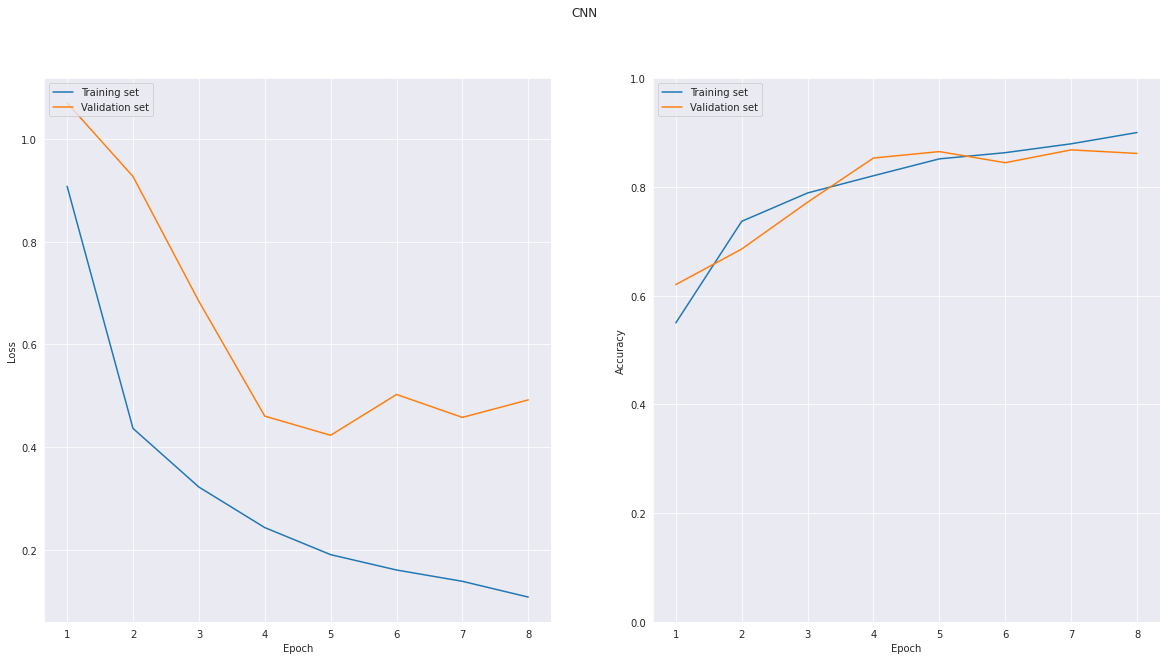

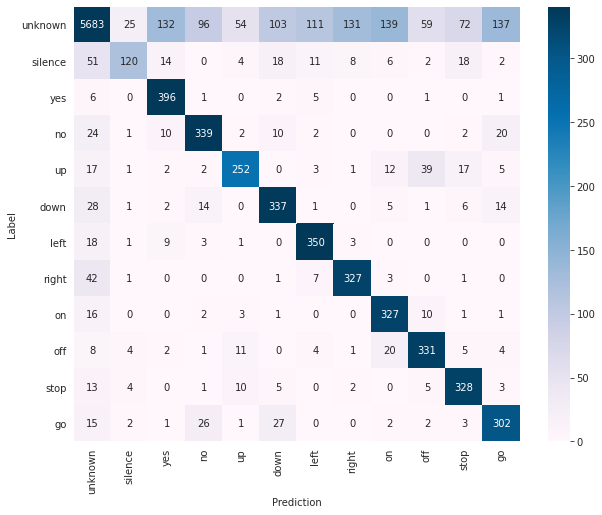

In [11]:
# Plot results
plt.figure(figsize=(20.0, 10.0))
plt.suptitle('{}'.format(model.name))
plt.subplot(1, 2, 1, label='Loss plot')
plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'])
plt.plot(
    np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.subplot(1, 2, 2, label='Accuracy plot')
plt.plot(np.arange(
    1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(
    1, len(history.history['val_acc'])+1), history.history['val_acc'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.savefig(_PATH_TO_RESULTS+'/images/training_process.png')


confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, cmap="PuBu", robust=True,
            xticklabels=params.WORDS, yticklabels=params.WORDS, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig(_PATH_TO_RESULTS+'/images/confusion_matrix.png')